In [36]:
import numpy as np
import pandas as pd
import sklearn
import sqlalchemy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder



#to ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Get data from local SQL database

In [9]:
# Create sqlalchemy connection for pandas read_sql functions
engine = sqlalchemy.create_engine("sqlite:///ba_scrape/beers.sqlite3")
conn = engine.connect()

In [12]:
beers = pd.read_sql_table("Beers", conn)
#engine.has_table("Beers")


In [14]:
beers.describe()

,abv,ratings,score
count,360999.000000,405202.000000,405202.000000
mean,6.573927,26.232005,3.268896
std,2.100378,225.992999,1.334406
min,0.010000,0.000000,0.000000
25%,5.100000,1.000000,3.350000
50%,6.000000,2.000000,3.750000
75%,7.500000,6.000000,4.000000
max,100.000000,17333.000000,5.000000


In [15]:
#Check if any styles are missing 
style_null = beers[beers['style'].isnull()]
style_null

In [17]:
#Drop rows where abv and style are NaN
beers = beers.dropna(subset=['abv', 'style'])

In [18]:
beers.describe()

,abv,ratings,score
count,360999.000000,360999.000000,360999.000000
mean,6.573927,28.901656,3.280186
std,2.100378,239.254527,1.333154
min,0.010000,0.000000,0.000000
25%,5.100000,1.000000,3.380000
50%,6.000000,2.000000,3.750000
75%,7.500000,7.000000,4.000000
max,100.000000,17333.000000,5.000000


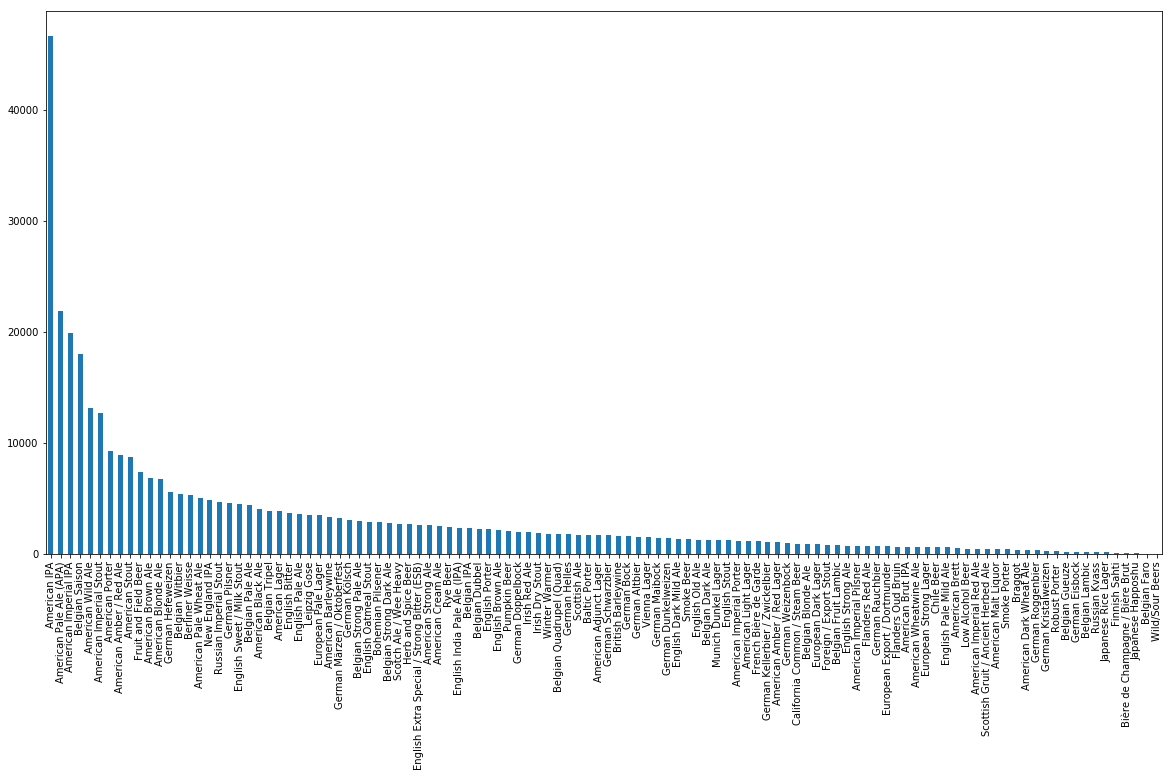

In [23]:
beers['style'].value_counts().plot(kind='bar', figsize=(20,10))
#plt.savefig('beer_styles.png', bbox_inches="tight")

Drop styles of beer with less than 5 counts

In [28]:
vc_style = beers['style'].value_counts()
vc_style_lt6 = vc_style[vc_style < 6]
styles_to_drop = list(vc_style_lt6.keys())
beers = beers[~beers['style'].isin(styles_to_drop)]

Plot box plots to see any outliers

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111]),
 <a list of 111 Text xticklabel objects>)

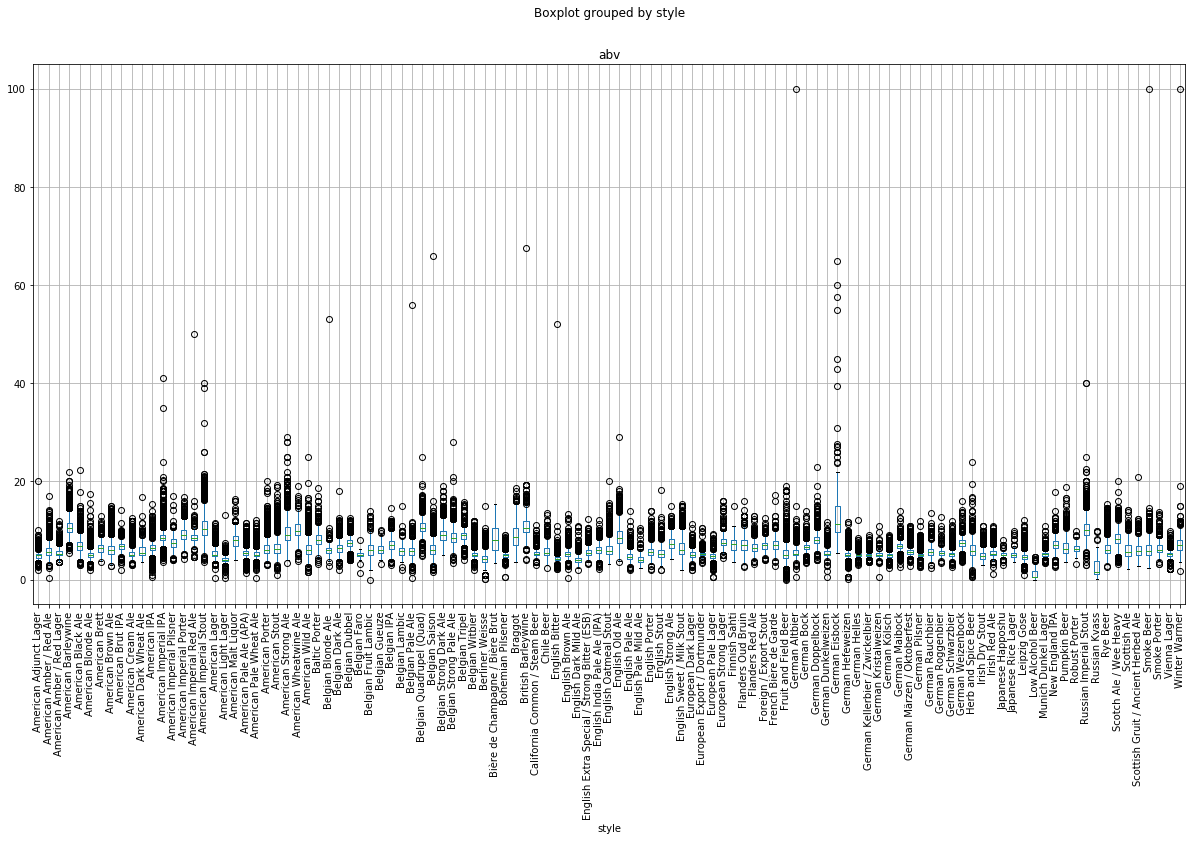

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
beers.boxplot(column=['abv'], by='style', ax=ax)
plt.xticks(rotation=90)

Remove data points with 100% abv

In [31]:
beers = beers[beers.abv < 90]

Let's leave the rest of the data points, most of the extreme outliers left are in styles with above average abv (Eisbock, American Strong Ale, etc.)

Now do Label Encoding and One-hot Encoding for beer styles

In [34]:
le = LabelEncoder()
le.fit(beers['style'])
beers['style'] = le.transform(beers['style']) 

In [37]:
ohe = OneHotEncoder()
style_csr = ohe.fit_transform(beers['style'].values.reshape(-1,1))

Pick model. Split into train and test data set. 

Then do k-fold cross validation on training data to see how the model performs. 

Then train model and test model with the test data set.

In [40]:
#Create training and test data
X = style_csr
y = beers.abv
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)

#Pick model
linreg = LinearRegression()

In [51]:
kfold = model_selection.KFold(n_splits=10, random_state=0)
results_train = model_selection.cross_val_score(linreg, X_train, y_train, cv=kfold, scoring="neg_mean_absolute_error")
print("Mean Absolute Error: %.3f (%.3f)" % (-1*results_train.mean(), results_train.std()))

Mean Absolute Error: 0.887 (0.004)


In [56]:
linreg.fit(X_train,y_train)

#Predict abv and calculate error
y_pred = linreg.predict(X_test)
result = sklearn.metrics.mean_absolute_error(y_test,y_pred)
print("%.3f" % (result))

0.889
